In [1]:
import diffrax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from dynax import (
    boxed_field,
    DynamicalSystem,
    fit_least_squares,
    Flow,
    non_negative_field,
    pretty,
)


np.random.seed(42)

Setting jax_enable_x64 to True.


# Example: parameter fitting of an ODE

In this example, we estimate the values and covariances of the parameters $m$, $r$, $r_2$ and $k$ of a forced, nonlinear mass-spring-damper system
$$
m ẍ +  r ẋ + r_2 ẋ |ẋ| + k x = u.
$$
We assume the measurement of the position $x$ in millineter, so the measurement equation is
$y = 1000x$.
Further, we have some prior knowledge of the system in terms of value bounds for the unknown parameters:
$$
\begin{align}
m &\in \mathbb R \\
r &\in [0, \infty) \\
r_2 &\in [0.01, 1] \\
k &\in [0.001, 2]
\end{align}
$$


In Dynax, the `DynamicalSystem` class models ODE with measurement equations. Bounds for trainable parameters arespecified with `boxed_field` or `non_negative_field`. Fixed parameters can be marked with `static_field`. 

In [2]:
class NonlinearDrag(DynamicalSystem):
    # Declare parameters as dataclass fields.
    m: float
    r: float = non_negative_field()
    r2: float = boxed_field(lower=0.01, upper=1)
    k: float = boxed_field(lower=1e-3, upper=2)

    # Set the initial state of the system and the number of inputs.
    initial_state = jnp.zeros(2)
    n_inputs = "scalar"

    # Define the vector field of the dynamical system.
    def vector_field(self, x, u, t):
        x1, x2 = x
        return jnp.array(
            [
                x2,
                (-self.r * x2 - self.r2 * jnp.abs(x2) * x2 - self.k * x1 + u) / self.m,
            ]
        )

    def output(self, x, u, t):
        return 1000 * x[0]

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


We combine an instance of the dynamical system with an ODE solver via the `Flow` class. Flows represent forward models that solve an ODE.

In [4]:
true_model = Flow(
    system=NonlinearDrag(m=1.0, r=2.0, r2=3.0, k=1.0),
    solver=diffrax.Dopri8(),
    stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
)
print("true forward model:", true_model)

true forward model: Flow(
  system=NonlinearDrag(
    initial_state(static)=f64[2],
    n_inputs(static)='scalar',
    m=1.0,
    r(boxed: (0.0, inf))=2.0,
    r2(boxed: (0.01, 1))=3.0,
    k(boxed: (0.001, 2))=1.0
  ),
  solver(static)=Dopri8(scan_kind=None),
  stepsize_controller(static)=PIDController(
    rtol=0.001,
    atol=1e-06,
    pcoeff=0,
    icoeff=1,
    dcoeff=0,
    dtmin=None,
    dtmax=None,
    force_dtmin=True,
    step_ts=None,
    jump_ts=None,
    factormin=0.2,
    factormax=10.0,
    norm=<function rms_norm>,
    safety=0.9,
    error_order=None
  )
)


Let's create some data with the forward model.

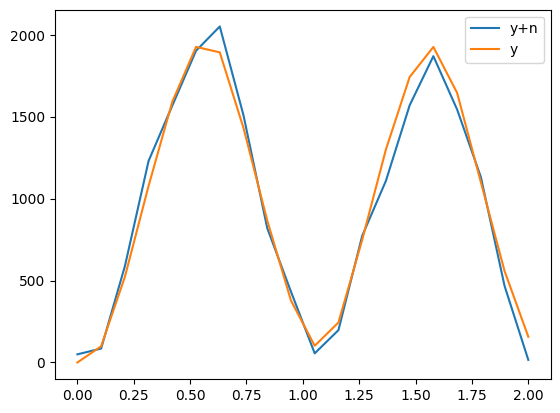

In [5]:
# time
t = jnp.linspace(0, 2, 20)
# forcing signal
u = 100 * jnp.sin(t * 2 * np.pi)
# x are the states and y is the output
x, y = true_model(t, u)
# add noise to measurement
yn = y + np.random.normal(size=y.shape, scale=100)

plt.plot(t, yn, label="y+n")
plt.plot(t, y, label="y")
plt.legend();

Let's create a new dynamical system object with some initial parameters that we want to fit.

In [7]:
init_model = Flow(
    system=NonlinearDrag(m=1.0, r=1.0, r2=1.0, k=1.0),
    solver=diffrax.Tsit5(),
    stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
)
print("initial system:", init_model)

initial system: Flow(
  system=NonlinearDrag(
    initial_state(static)=f64[2],
    n_inputs(static)='scalar',
    m=1.0,
    r(boxed: (0.0, inf))=1.0,
    r2(boxed: (0.01, 1))=1.0,
    k(boxed: (0.001, 2))=1.0
  ),
  solver(static)=Tsit5(scan_kind=None),
  stepsize_controller(static)=PIDController(
    rtol=0.001,
    atol=1e-06,
    pcoeff=0,
    icoeff=1,
    dcoeff=0,
    dtmin=None,
    dtmax=None,
    force_dtmin=True,
    step_ts=None,
    jump_ts=None,
    factormin=0.2,
    factormax=10.0,
    norm=<function rms_norm>,
    safety=0.9,
    error_order=None
  )
)


Combine the initial ODE system with an ODE solver and fit it using nonlinear Least-Squares.

In [8]:
res = fit_least_squares(model=init_model, t=t, y=yn, u=u, verbose=2)
pred_model = res.result
print("fitted system:", pretty(pred_model.system))
print("Normalized mean squared error:", res.nrmse)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6932e+00                                    5.19e-01    
       1              2         1.2050e-01      1.57e+00       6.56e+00       7.58e-02    
       2              3         2.1584e-02      9.89e-02       2.69e+00       1.97e-02    
       3              4         1.8803e-02      2.78e-03       3.26e-01       2.40e-03    
       4              5         1.8095e-02      7.08e-04       3.40e-01       2.85e-03    
       5              6         1.7878e-02      2.17e-04       2.22e-01       1.79e-03    
       6              7         1.7854e-02      2.34e-05       1.01e-01       8.56e-04    
       7             10         1.7842e-02      1.26e-05       6.96e-03       7.91e-05    
       8             16         1.7842e-02      7.74e-08       1.66e-05       7.91e-05    
       9             18         1.7842e-02      1.64e-09       8.29e-06       7.95e-05    

Compare true and estimated output.

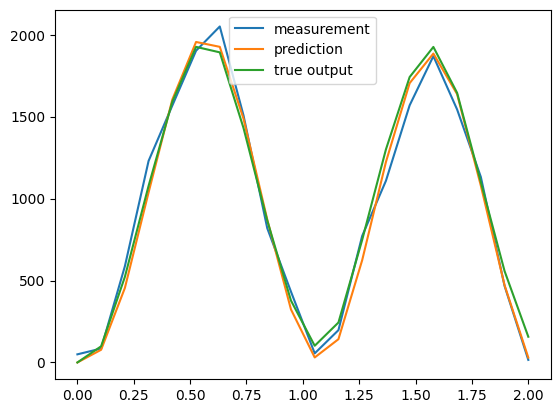

In [9]:
x_pred, _ = pred_model(t, u)

plt.plot(t, yn, label="measurement")
plt.plot(t, res.y_pred, label="prediction")
plt.plot(t, y, label="true output")

plt.legend()
plt.show()

`fit_least_squares` also estimates the covariance matrix of the parameter estimates.

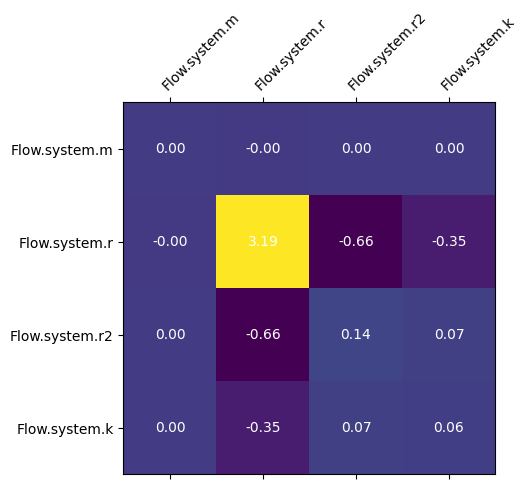

In [10]:
def plot_covariance(res):
    nparams = len(res.key_paths)

    plt.matshow(res.pcov)
    ax = plt.gca()
    ax.set_xticks(np.arange(nparams), labels=res.key_paths)
    ax.set_yticks(np.arange(nparams), labels=res.key_paths)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

    for i in range(nparams):
        for j in range(nparams):
            ax.text(j, i, f"{res.pcov[i, j]:.2f}", ha="center", va="center", color="w")


plot_covariance(res)

The parameter standard deviations are:

In [11]:
for kp, var in zip(res.key_paths, np.diag(res.pcov), strict=True):
    print(f"{kp}: {np.sqrt(var):.3f}")

Flow.system.m: 0.022
Flow.system.r: 1.785
Flow.system.r2: 0.372
Flow.system.k: 0.235
